In [1]:
import zipfile

# Extract the first dataset
with zipfile.ZipFile('/content/rpi.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')

# Extract the second dataset
with zipfile.ZipFile('/content/all.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')


In [2]:
import os
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming previous definitions and imports are available

def gather_paths_simple(base_dir, categories):
    path_dict = {}
    for category in categories:
        file_extension = "*.tif" if "manual1" in category else "*.jpg"
        path_dict[category] = sorted(glob.glob(f"{base_dir}/{category}/" + file_extension))
    return path_dict

# Load image function with a check for mask presence
def load_image(filename, is_mask=False, target_size=(256, 256)):
    img = load_img(filename, target_size=target_size, color_mode='grayscale' if is_mask else 'rgb')
    img = img_to_array(img)
    if is_mask:
        img = (img > 127).astype(np.float32)  # Binarize mask
    else:
        img = img.astype(np.float32) / 255.0  # Normalize image
    return img.squeeze(-1) if is_mask else img

# Paths for images and masks
second_dataset_path = "/content/sample_data"
categories_second = ["images", "manual1"]
paths = gather_paths_simple(second_dataset_path, categories_second)

# Extracting base names to pair images and masks
image_names = set(os.path.splitext(os.path.basename(x))[0] for x in paths['images'])
mask_names = set(os.path.splitext(os.path.basename(x))[0] for x in paths['manual1'])

# Find common names that have both image and mask
common_names = image_names & mask_names
paired_images = [x for x in paths['images'] if os.path.splitext(os.path.basename(x))[0] in common_names]
paired_masks = [x for x in paths['manual1'] if os.path.splitext(os.path.basename(x))[0] in common_names]

# Load images and masks that are paired
all_images = [load_image(f) for f in paired_images]
all_masks = [load_image(f, is_mask=True) for f in paired_masks]

# Convert to numpy arrays
all_images = np.array(all_images)
all_masks = np.array(all_masks)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(all_images, all_masks, test_size=0.2, random_state=42)

# Print dataset sizes to confirm correct loading
print("Training set shapes: Images {}, Masks {}".format(X_train.shape, y_train.shape))
print("Validation set shapes: Images {}, Masks {}".format(X_val.shape, y_val.shape))


Training set shapes: Images (24, 256, 256, 3), Masks (24, 256, 256)
Validation set shapes: Images (6, 256, 256, 3), Masks (6, 256, 256)


In [ ]:
from sklearn.model_selection import train_test_split

# Parameters
img_height = 256
img_width = 256

def load_image(filename, size=(img_height, img_width)):
    # Load the image
    pixels = Image.open(filename)
    # Resize the image
    pixels = pixels.resize(size, Image.ANTIALIAS)
    # Convert to numpy array
    pixels = np.array(pixels)
    # Normalize and clip pixel values
    pixels = ((pixels - 127.5) / 127.5) + 0.5
    pixels = np.clip(pixels, 0, 1)
    return pixels

# Load all images and masks into memory
all_images = [load_image(file) for file in images_path['images']['training']]
all_masks = [load_image(file) for file in images_path['1st_manual']['training']]

# Convert lists to numpy arrays
all_images = np.array(all_images)
all_masks = np.array(all_masks)

# Split into training and validation sets
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(all_images, all_masks, test_size=0.2, random_state=42)

# Normalize the masks
y_train_normalized = y_train / 255.0
y_val_normalized = y_val / 255.0


<ipython-input-5-eb5102cefc97>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pixels = pixels.resize(size, Image.ANTIALIAS)


In [6]:
!pip install -U -q segmentation-models
#!pip uninstall -y tensorflow
!pip install tensorflow==2.2.0
!pip install -q keras==2.15.0

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
from keras.layers import Input, Conv2D, Conv2DTranspose, Activation, BatchNormalization, add, multiply, UpSampling2D, concatenate
from keras.models import Model

# Set the framework for segmentation_models
sm.set_framework('tf.keras')

# Set the framework for segmentation_models
sm.set_framework('tf.keras')

def attention_gate(inputs, gate_signal, inter_channels):
    theta_x = Conv2D(inter_channels, (1, 1), strides=(2, 2), padding='same')(inputs)
    phi_g = Conv2D(inter_channels, (1, 1), padding='same')(gate_signal)
    upsample_theta_x = UpSampling2D(size=(2, 2))(theta_x)
    concat_xg = add([upsample_theta_x, phi_g])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(act_xg)
    return multiply([inputs, psi])

def decoder_block(input_tensor, concat_tensor, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    attention = attention_gate(concat_tensor, x, num_filters // 2)
    x = concatenate([x, attention], axis=-1)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def create_efficient_unet(input_shape):
    backbone = sm.Unet('efficientnetb0', encoder_weights='imagenet', encoder_freeze=True, input_shape=input_shape, classes=1, activation='sigmoid')
    # Using the backbone's layers directly as inputs and outputs for clarity
    input_tensor = backbone.input
    outputs = backbone.output

    model = Model(inputs=[input_tensor], outputs=[outputs])
    return model

input_shape = (256, 256, 3)
model = create_efficient_unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.2.0
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 stem_conv (

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import glob
import imageio

# Make sure to point to the correct directory and include the wildcard '*' to capture the files
image_file_paths = sorted(glob.glob('/content/sample_data/images/*.jpg'))  # JPG files for images
mask_file_paths = sorted(glob.glob('/content/sample_data/manual1/*.tif'))  # TIF files for masks

# Load the first image and mask from the sorted list of file paths
image_path = image_file_paths[0]  # First image file
mask_path = mask_file_paths[0]    # First mask file

# Read and process the image
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image, [256, 256])
image = np.expand_dims(image.numpy(), axis=0)  # Add batch dimension

# Read and process the mask using imageio for TIF files
mask = imageio.mimread(mask_path, memtest=False)[0]  # Read the first frame
# Make sure the mask has the correct number of dimensions
if mask.ndim == 2:
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension for grayscale
mask = np.expand_dims(mask, axis=0)  # Add batch dimension
mask = tf.convert_to_tensor(mask, dtype=tf.float32)  # Convert to TensorFlow tensor
mask = tf.image.resize(mask, [256, 256], method='nearest')

# Define data augmentation parameters
data_augmentation = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'

# Create ImageDataGenerator instances for both the image and the mask
image_datagen = ImageDataGenerator(**augmentation_parameters)
mask_datagen = ImageDataGenerator(**augmentation_parameters)

# Set up the generators using the same seed to ensure matching pairs
seed = 42
image_generator = image_datagen.flow(image, batch_size=1, seed=seed)
mask_generator = mask_datagen.flow(mask, batch_size=1, seed=seed)

# Function to plot augmented images and masks
def plot_augmented_images(image_gen, mask_gen, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))
    for i in range(num_images):
        augmented_image = next(image_gen)[0].astype(np.uint8)
        augmented_mask = next(mask_gen)[0].squeeze()
        axes[i, 0].imshow(augmented_image)
        axes[i, 0].set_title('Augmented Image')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(augmented_mask, cmap='gray')
        axes[i, 1].set_title('Augmented Mask')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

# Plot the augmented images and masks
plot_augmented_images(image_generator, mask_generator, num_images=5)


In [18]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, save_freq):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            self.model.save(filepath, overwrite=True)
            print(f'\nSaved model to {filepath} at epoch {epoch + 1}')

# Assuming y_train_normalized, y_val_normalized are numpy arrays of your data,
# and assuming X_train, X_val are your input data (images)
input_shape = (256, 256, 3)

# Create the model using the custom U-Net function with EfficientNetB0 backbone
model = create_efficient_unet(input_shape=input_shape)

# Compile the model with binary_crossentropy loss
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define data augmentation parameters
data_augmentation = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Create data generators for training and validation with data augmentation
train_data_generator = data_augmentation.flow(X_train, y_train_normalized, batch_size=16)
val_data_generator = ImageDataGenerator().flow(X_val, y_val_normalized)

# Define the callbacks
checkpointer = CustomModelCheckpoint(filepath='/mnt/data/model_for_segmentation_epoch_{epoch:04d}.h5', save_freq=100)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.5, verbose=1)

# Fit the model
history = model.fit(
    train_data_generator,
    steps_per_epoch=len(X_train) // 16,
    epochs=300,
    validation_data=val_data_generator,
    validation_steps=len(X_val),
    callbacks=[checkpointer, reduce_lr]
)


Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.5045 - accuracy: 0.7531

1/1 [==============================] - 23s 23s/step - loss: 0.5045 - accuracy: 0.7531 - val_loss: 0.4013 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.4634 - accuracy: 0.7788

1/1 [==============================] - 1s 503ms/step - loss: 0.4634 - accuracy: 0.7788 - lr: 0.0010
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.4311 - accuracy: 0.8273

1/1 [==============================] - 1s 717ms/step - loss: 0.4311 - accuracy: 0.8273 - lr: 0.0010
Epoch 4/300
1/1 [==============================] - ETA: 0s - loss: 0.4039 - accuracy: 0.8544

1/1 [==============================] - 1s 518ms/step - loss: 0.4039 - accuracy: 0.8544 - lr: 0.0010
Epoch 5/300
1/1 [==============================] - ETA: 0s - loss: 0.3768 - accuracy: 0.8742

1/1 [==============================] - 0s 302ms/step - loss: 0.3768 - accuracy: 0.8742 - lr: 0.0010
Epoch 6/300
1/1 [==============================] - ETA: 0s - loss: 0.3529 - accuracy: 0.8899

1/1 [==============================] - 0s 294ms/step - loss: 0.3529 - accuracy: 0.8899 - lr: 0.0010
Epoch 7/300
1/1 [==============================] - ETA: 0s - loss: 0.3321 - accuracy: 0.9047

1/1 [==============================] - 0s 291ms/step - loss: 0.3321 - accuracy: 0.9047 - lr: 0.0010
Epoch 8/300
1/1 [==============================] - ETA: 0s - loss: 0.3087 - accuracy: 0.9119

1/1 [==============================] - 1s 519ms/step - loss: 0.3087 - accuracy: 0.9119 - lr: 0.0010
Epoch 9/300
1/1 [==============================] - ETA: 0s - loss: 0.2891 - accuracy: 0.9156

1/1 [==============================] - 1s 512ms/step - loss: 0.2891 - accuracy: 0.9156 - lr: 0.0010
Epoch 10/300
1/1 [==============================] - ETA: 0s - loss: 0.2697 - accuracy: 0.9158

1/1 [==============================] - 0s 294ms/step - loss: 0.2697 - accuracy: 0.9158 - lr: 0.0010
Epoch 11/300
1/1 [==============================] - ETA: 0s - loss: 0.2524 - accuracy: 0.9190

1/1 [==============================] - 0s 298ms/step - loss: 0.2524 - accuracy: 0.9190 - lr: 0.0010
Epoch 12/300
1/1 [==============================] - ETA: 0s - loss: 0.2384 - accuracy: 0.9195

1/1 [==============================] - 0s 299ms/step - loss: 0.2384 - accuracy: 0.9195 - lr: 0.0010
Epoch 13/300
1/1 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.9208

1/1 [==============================] - 1s 521ms/step - loss: 0.2218 - accuracy: 0.9208 - lr: 0.0010
Epoch 14/300
1/1 [==============================] - ETA: 0s - loss: 0.2068 - accuracy: 0.9121

1/1 [==============================] - 0s 305ms/step - loss: 0.2068 - accuracy: 0.9121 - lr: 0.0010
Epoch 15/300
1/1 [==============================] - ETA: 0s - loss: 0.1945 - accuracy: 0.9183

1/1 [==============================] - 1s 514ms/step - loss: 0.1945 - accuracy: 0.9183 - lr: 0.0010
Epoch 16/300
1/1 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9209

1/1 [==============================] - 0s 300ms/step - loss: 0.1833 - accuracy: 0.9209 - lr: 0.0010
Epoch 17/300
1/1 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.9160

1/1 [==============================] - 0s 293ms/step - loss: 0.1710 - accuracy: 0.9160 - lr: 0.0010
Epoch 18/300
1/1 [==============================] - ETA: 0s - loss: 0.1616 - accuracy: 0.9186

1/1 [==============================] - 1s 521ms/step - loss: 0.1616 - accuracy: 0.9186 - lr: 0.0010
Epoch 19/300
1/1 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9221

1/1 [==============================] - 0s 294ms/step - loss: 0.1523 - accuracy: 0.9221 - lr: 0.0010
Epoch 20/300
1/1 [==============================] - ETA: 0s - loss: 0.1421 - accuracy: 0.9189

1/1 [==============================] - 0s 294ms/step - loss: 0.1421 - accuracy: 0.9189 - lr: 0.0010
Epoch 21/300
1/1 [==============================] - ETA: 0s - loss: 0.1348 - accuracy: 0.9215

1/1 [==============================] - 1s 510ms/step - loss: 0.1348 - accuracy: 0.9215 - lr: 0.0010
Epoch 22/300
1/1 [==============================] - ETA: 0s - loss: 0.1268 - accuracy: 0.9221

1/1 [==============================] - 0s 310ms/step - loss: 0.1268 - accuracy: 0.9221 - lr: 0.0010
Epoch 23/300
1/1 [==============================] - ETA: 0s - loss: 0.1191 - accuracy: 0.9210

1/1 [==============================] - 1s 748ms/step - loss: 0.1191 - accuracy: 0.9210 - lr: 0.0010
Epoch 24/300
1/1 [==============================] - ETA: 0s - loss: 0.1125 - accuracy: 0.9222

1/1 [==============================] - 1s 783ms/step - loss: 0.1125 - accuracy: 0.9222 - lr: 0.0010
Epoch 25/300
1/1 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.9201

1/1 [==============================] - 0s 291ms/step - loss: 0.1064 - accuracy: 0.9201 - lr: 0.0010
Epoch 26/300
1/1 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.9183

1/1 [==============================] - 0s 291ms/step - loss: 0.1017 - accuracy: 0.9183 - lr: 0.0010
Epoch 27/300
1/1 [==============================] - ETA: 0s - loss: 0.0961 - accuracy: 0.9192

1/1 [==============================] - 0s 295ms/step - loss: 0.0961 - accuracy: 0.9192 - lr: 0.0010
Epoch 28/300
1/1 [==============================] - ETA: 0s - loss: 0.0898 - accuracy: 0.9180

1/1 [==============================] - 0s 292ms/step - loss: 0.0898 - accuracy: 0.9180 - lr: 0.0010
Epoch 29/300
1/1 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9267

1/1 [==============================] - 0s 309ms/step - loss: 0.0862 - accuracy: 0.9267 - lr: 0.0010
Epoch 30/300
1/1 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 0.9248

1/1 [==============================] - 0s 292ms/step - loss: 0.0816 - accuracy: 0.9248 - lr: 0.0010
Epoch 31/300
1/1 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.9233

1/1 [==============================] - 0s 305ms/step - loss: 0.0780 - accuracy: 0.9233 - lr: 0.0010
Epoch 32/300
1/1 [==============================] - ETA: 0s - loss: 0.0728 - accuracy: 0.9250

1/1 [==============================] - 0s 298ms/step - loss: 0.0728 - accuracy: 0.9250 - lr: 0.0010
Epoch 33/300
1/1 [==============================] - ETA: 0s - loss: 0.0695 - accuracy: 0.9207

1/1 [==============================] - 0s 286ms/step - loss: 0.0695 - accuracy: 0.9207 - lr: 0.0010
Epoch 34/300
1/1 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9193

1/1 [==============================] - 1s 529ms/step - loss: 0.0664 - accuracy: 0.9193 - lr: 0.0010
Epoch 35/300
1/1 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.9183

1/1 [==============================] - 1s 533ms/step - loss: 0.0633 - accuracy: 0.9183 - lr: 0.0010
Epoch 36/300
1/1 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9113

1/1 [==============================] - 0s 289ms/step - loss: 0.0603 - accuracy: 0.9113 - lr: 0.0010
Epoch 37/300
1/1 [==============================] - ETA: 0s - loss: 0.0577 - accuracy: 0.9201

1/1 [==============================] - 0s 292ms/step - loss: 0.0577 - accuracy: 0.9201 - lr: 0.0010
Epoch 38/300
1/1 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9199

1/1 [==============================] - 1s 518ms/step - loss: 0.0549 - accuracy: 0.9199 - lr: 0.0010
Epoch 39/300
1/1 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9139

1/1 [==============================] - 0s 302ms/step - loss: 0.0532 - accuracy: 0.9139 - lr: 0.0010
Epoch 40/300
1/1 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9166

1/1 [==============================] - 0s 296ms/step - loss: 0.0511 - accuracy: 0.9166 - lr: 0.0010
Epoch 41/300
1/1 [==============================] - ETA: 0s - loss: 0.0490 - accuracy: 0.9242

1/1 [==============================] - 0s 291ms/step - loss: 0.0490 - accuracy: 0.9242 - lr: 0.0010
Epoch 42/300
1/1 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.9209

1/1 [==============================] - 1s 511ms/step - loss: 0.0465 - accuracy: 0.9209 - lr: 0.0010
Epoch 43/300
1/1 [==============================] - ETA: 0s - loss: 0.0452 - accuracy: 0.9247

1/1 [==============================] - 0s 283ms/step - loss: 0.0452 - accuracy: 0.9247 - lr: 0.0010
Epoch 44/300
1/1 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9268

1/1 [==============================] - 0s 295ms/step - loss: 0.0433 - accuracy: 0.9268 - lr: 0.0010
Epoch 45/300
1/1 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.9229

1/1 [==============================] - 1s 671ms/step - loss: 0.0414 - accuracy: 0.9229 - lr: 0.0010
Epoch 46/300
1/1 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9184

1/1 [==============================] - 1s 762ms/step - loss: 0.0398 - accuracy: 0.9184 - lr: 0.0010
Epoch 47/300
1/1 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9202

1/1 [==============================] - 1s 729ms/step - loss: 0.0388 - accuracy: 0.9202 - lr: 0.0010
Epoch 48/300
1/1 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9192

1/1 [==============================] - 1s 743ms/step - loss: 0.0377 - accuracy: 0.9192 - lr: 0.0010
Epoch 49/300
1/1 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9219

1/1 [==============================] - 1s 516ms/step - loss: 0.0358 - accuracy: 0.9219 - lr: 0.0010
Epoch 50/300
1/1 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.9197

1/1 [==============================] - 1s 530ms/step - loss: 0.0348 - accuracy: 0.9197 - lr: 0.0010
Epoch 51/300
1/1 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9216

1/1 [==============================] - 1s 523ms/step - loss: 0.0335 - accuracy: 0.9216 - lr: 0.0010
Epoch 52/300
1/1 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9278

1/1 [==============================] - 0s 311ms/step - loss: 0.0328 - accuracy: 0.9278 - lr: 0.0010
Epoch 53/300
1/1 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9168

1/1 [==============================] - 1s 522ms/step - loss: 0.0317 - accuracy: 0.9168 - lr: 0.0010
Epoch 54/300
1/1 [==============================] - ETA: 0s - loss: 0.0307 - accuracy: 0.9207

1/1 [==============================] - 1s 531ms/step - loss: 0.0307 - accuracy: 0.9207 - lr: 0.0010
Epoch 55/300
1/1 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9229

1/1 [==============================] - 0s 291ms/step - loss: 0.0296 - accuracy: 0.9229 - lr: 0.0010
Epoch 56/300
1/1 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9219

1/1 [==============================] - 1s 510ms/step - loss: 0.0288 - accuracy: 0.9219 - lr: 0.0010
Epoch 57/300
1/1 [==============================] - ETA: 0s - loss: 0.0278 - accuracy: 0.9205

1/1 [==============================] - 1s 505ms/step - loss: 0.0278 - accuracy: 0.9205 - lr: 0.0010
Epoch 58/300
1/1 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9202

1/1 [==============================] - 0s 310ms/step - loss: 0.0274 - accuracy: 0.9202 - lr: 0.0010
Epoch 59/300
1/1 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.9136

1/1 [==============================] - 0s 287ms/step - loss: 0.0265 - accuracy: 0.9136 - lr: 0.0010
Epoch 60/300
1/1 [==============================] - ETA: 0s - loss: 0.0257 - accuracy: 0.9220

1/1 [==============================] - 0s 293ms/step - loss: 0.0257 - accuracy: 0.9220 - lr: 0.0010
Epoch 61/300
1/1 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9137

1/1 [==============================] - 0s 300ms/step - loss: 0.0251 - accuracy: 0.9137 - lr: 0.0010
Epoch 62/300
1/1 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9169

1/1 [==============================] - 0s 295ms/step - loss: 0.0246 - accuracy: 0.9169 - lr: 0.0010
Epoch 63/300
1/1 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9262

1/1 [==============================] - 0s 309ms/step - loss: 0.0240 - accuracy: 0.9262 - lr: 0.0010
Epoch 64/300
1/1 [==============================] - ETA: 0s - loss: 0.0233 - accuracy: 0.9167

1/1 [==============================] - 0s 292ms/step - loss: 0.0233 - accuracy: 0.9167 - lr: 0.0010
Epoch 65/300
1/1 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9230

1/1 [==============================] - 0s 303ms/step - loss: 0.0227 - accuracy: 0.9230 - lr: 0.0010
Epoch 66/300
1/1 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.9179

1/1 [==============================] - 1s 513ms/step - loss: 0.0223 - accuracy: 0.9179 - lr: 0.0010
Epoch 67/300
1/1 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9177

1/1 [==============================] - 0s 290ms/step - loss: 0.0221 - accuracy: 0.9177 - lr: 0.0010
Epoch 68/300
1/1 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9215

1/1 [==============================] - 1s 746ms/step - loss: 0.0214 - accuracy: 0.9215 - lr: 0.0010
Epoch 69/300
1/1 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9210

1/1 [==============================] - 1s 719ms/step - loss: 0.0209 - accuracy: 0.9210 - lr: 0.0010
Epoch 70/300
1/1 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9209

1/1 [==============================] - 0s 293ms/step - loss: 0.0204 - accuracy: 0.9209 - lr: 0.0010
Epoch 71/300
1/1 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9205

1/1 [==============================] - 1s 517ms/step - loss: 0.0200 - accuracy: 0.9205 - lr: 0.0010
Epoch 72/300
1/1 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 0.9176

1/1 [==============================] - 1s 519ms/step - loss: 0.0197 - accuracy: 0.9176 - lr: 0.0010
Epoch 73/300
1/1 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9167

1/1 [==============================] - 1s 516ms/step - loss: 0.0193 - accuracy: 0.9167 - lr: 0.0010
Epoch 74/300
1/1 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9217

1/1 [==============================] - 0s 299ms/step - loss: 0.0188 - accuracy: 0.9217 - lr: 0.0010
Epoch 75/300
1/1 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9200

1/1 [==============================] - 1s 500ms/step - loss: 0.0188 - accuracy: 0.9200 - lr: 0.0010
Epoch 76/300
1/1 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9189

1/1 [==============================] - 0s 302ms/step - loss: 0.0183 - accuracy: 0.9189 - lr: 0.0010
Epoch 77/300
1/1 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9211

1/1 [==============================] - 1s 510ms/step - loss: 0.0180 - accuracy: 0.9211 - lr: 0.0010
Epoch 78/300
1/1 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9217

1/1 [==============================] - 1s 526ms/step - loss: 0.0175 - accuracy: 0.9217 - lr: 0.0010
Epoch 79/300
1/1 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9207

1/1 [==============================] - 1s 515ms/step - loss: 0.0173 - accuracy: 0.9207 - lr: 0.0010
Epoch 80/300
1/1 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9189

1/1 [==============================] - 1s 523ms/step - loss: 0.0170 - accuracy: 0.9189 - lr: 0.0010
Epoch 81/300
1/1 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9217

1/1 [==============================] - 1s 518ms/step - loss: 0.0168 - accuracy: 0.9217 - lr: 0.0010
Epoch 82/300
1/1 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9203

1/1 [==============================] - 0s 294ms/step - loss: 0.0164 - accuracy: 0.9203 - lr: 0.0010
Epoch 83/300
1/1 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9186

1/1 [==============================] - 1s 524ms/step - loss: 0.0162 - accuracy: 0.9186 - lr: 0.0010
Epoch 84/300
1/1 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9191

1/1 [==============================] - 1s 513ms/step - loss: 0.0160 - accuracy: 0.9191 - lr: 0.0010
Epoch 85/300
1/1 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9193

1/1 [==============================] - 1s 513ms/step - loss: 0.0157 - accuracy: 0.9193 - lr: 0.0010
Epoch 86/300
1/1 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9150

1/1 [==============================] - 0s 296ms/step - loss: 0.0155 - accuracy: 0.9150 - lr: 0.0010
Epoch 87/300
1/1 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9154

1/1 [==============================] - 0s 449ms/step - loss: 0.0156 - accuracy: 0.9154 - lr: 0.0010
Epoch 88/300
1/1 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9212

1/1 [==============================] - 1s 762ms/step - loss: 0.0149 - accuracy: 0.9212 - lr: 0.0010
Epoch 89/300
1/1 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9166

1/1 [==============================] - 1s 529ms/step - loss: 0.0147 - accuracy: 0.9166 - lr: 0.0010
Epoch 90/300
1/1 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9149

1/1 [==============================] - 0s 293ms/step - loss: 0.0146 - accuracy: 0.9149 - lr: 0.0010
Epoch 91/300
1/1 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9203

1/1 [==============================] - 1s 506ms/step - loss: 0.0144 - accuracy: 0.9203 - lr: 0.0010
Epoch 92/300
1/1 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9167

1/1 [==============================] - 0s 292ms/step - loss: 0.0141 - accuracy: 0.9167 - lr: 0.0010
Epoch 93/300
1/1 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9228

1/1 [==============================] - 0s 290ms/step - loss: 0.0139 - accuracy: 0.9228 - lr: 0.0010
Epoch 94/300
1/1 [==============================] - ETA: 0s - loss: 0.0136 - accuracy: 0.9246

1/1 [==============================] - 0s 301ms/step - loss: 0.0136 - accuracy: 0.9246 - lr: 0.0010
Epoch 95/300
1/1 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9201

1/1 [==============================] - 1s 518ms/step - loss: 0.0135 - accuracy: 0.9201 - lr: 0.0010
Epoch 96/300
1/1 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9192

1/1 [==============================] - 1s 513ms/step - loss: 0.0134 - accuracy: 0.9192 - lr: 0.0010
Epoch 97/300
1/1 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9222

1/1 [==============================] - 0s 290ms/step - loss: 0.0133 - accuracy: 0.9222 - lr: 0.0010
Epoch 98/300
1/1 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9234

1/1 [==============================] - 1s 515ms/step - loss: 0.0130 - accuracy: 0.9234 - lr: 0.0010
Epoch 99/300
1/1 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9214

1/1 [==============================] - 1s 520ms/step - loss: 0.0128 - accuracy: 0.9214 - lr: 0.0010
Epoch 100/300
1/1 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9131


Saved model to /mnt/data/model_for_segmentation_epoch_0100.h5 at epoch 100
1/1 [==============================] - 1s 1s/step - loss: 0.0127 - accuracy: 0.9131 - lr: 0.0010
Epoch 101/300
1/1 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9144

1/1 [==============================] - 0s 297ms/step - loss: 0.0126 - accuracy: 0.9144 - lr: 0.0010
Epoch 102/300
1/1 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9214

1/1 [==============================] - 0s 298ms/step - loss: 0.0124 - accuracy: 0.9214 - lr: 0.0010
Epoch 103/300
1/1 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9196

1/1 [==============================] - 1s 534ms/step - loss: 0.0122 - accuracy: 0.9196 - lr: 0.0010
Epoch 104/300
1/1 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9220

1/1 [==============================] - 1s 502ms/step - loss: 0.0120 - accuracy: 0.9220 - lr: 0.0010
Epoch 105/300
1/1 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 0.9202

1/1 [==============================] - 0s 293ms/step - loss: 0.0121 - accuracy: 0.9202 - lr: 0.0010
Epoch 106/300
1/1 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9175

1/1 [==============================] - 0s 342ms/step - loss: 0.0120 - accuracy: 0.9175 - lr: 0.0010
Epoch 107/300
1/1 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9175

1/1 [==============================] - 0s 448ms/step - loss: 0.0118 - accuracy: 0.9175 - lr: 0.0010
Epoch 108/300
1/1 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9152

1/1 [==============================] - 0s 434ms/step - loss: 0.0117 - accuracy: 0.9152 - lr: 0.0010
Epoch 109/300
1/1 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9227

1/1 [==============================] - 1s 720ms/step - loss: 0.0114 - accuracy: 0.9227 - lr: 0.0010
Epoch 110/300
1/1 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9201

1/1 [==============================] - 0s 290ms/step - loss: 0.0114 - accuracy: 0.9201 - lr: 0.0010
Epoch 111/300
1/1 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9205

1/1 [==============================] - 1s 511ms/step - loss: 0.0112 - accuracy: 0.9205 - lr: 0.0010
Epoch 112/300
1/1 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9193

1/1 [==============================] - 1s 515ms/step - loss: 0.0110 - accuracy: 0.9193 - lr: 0.0010
Epoch 113/300
1/1 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9171

1/1 [==============================] - 0s 290ms/step - loss: 0.0110 - accuracy: 0.9171 - lr: 0.0010
Epoch 114/300
1/1 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9238

1/1 [==============================] - 0s 292ms/step - loss: 0.0108 - accuracy: 0.9238 - lr: 0.0010
Epoch 115/300
1/1 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9227

1/1 [==============================] - 1s 533ms/step - loss: 0.0107 - accuracy: 0.9227 - lr: 0.0010
Epoch 116/300
1/1 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9209

1/1 [==============================] - 1s 513ms/step - loss: 0.0107 - accuracy: 0.9209 - lr: 0.0010
Epoch 117/300
1/1 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9148

1/1 [==============================] - 0s 295ms/step - loss: 0.0106 - accuracy: 0.9148 - lr: 0.0010
Epoch 118/300
1/1 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9177

1/1 [==============================] - 1s 510ms/step - loss: 0.0104 - accuracy: 0.9177 - lr: 0.0010
Epoch 119/300
1/1 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9223

1/1 [==============================] - 1s 518ms/step - loss: 0.0102 - accuracy: 0.9223 - lr: 0.0010
Epoch 120/300
1/1 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9198

1/1 [==============================] - 1s 515ms/step - loss: 0.0102 - accuracy: 0.9198 - lr: 0.0010
Epoch 121/300
1/1 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9171

1/1 [==============================] - 0s 298ms/step - loss: 0.0103 - accuracy: 0.9171 - lr: 0.0010
Epoch 122/300
1/1 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9188

1/1 [==============================] - 0s 300ms/step - loss: 0.0100 - accuracy: 0.9188 - lr: 0.0010
Epoch 123/300
1/1 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9207

1/1 [==============================] - 1s 525ms/step - loss: 0.0098 - accuracy: 0.9207 - lr: 0.0010
Epoch 124/300
1/1 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9288

1/1 [==============================] - 0s 302ms/step - loss: 0.0097 - accuracy: 0.9288 - lr: 0.0010
Epoch 125/300
1/1 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9229

1/1 [==============================] - 1s 513ms/step - loss: 0.0097 - accuracy: 0.9229 - lr: 0.0010
Epoch 126/300
1/1 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.9198

1/1 [==============================] - 1s 520ms/step - loss: 0.0096 - accuracy: 0.9198 - lr: 0.0010
Epoch 127/300
1/1 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9193

1/1 [==============================] - 1s 535ms/step - loss: 0.0095 - accuracy: 0.9193 - lr: 0.0010
Epoch 128/300
1/1 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9182

1/1 [==============================] - 0s 445ms/step - loss: 0.0095 - accuracy: 0.9182 - lr: 0.0010
Epoch 129/300
1/1 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.9232

1/1 [==============================] - 1s 761ms/step - loss: 0.0093 - accuracy: 0.9232 - lr: 0.0010
Epoch 130/300
1/1 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9198

1/1 [==============================] - 1s 527ms/step - loss: 0.0092 - accuracy: 0.9198 - lr: 0.0010
Epoch 131/300
1/1 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.9241

1/1 [==============================] - 0s 293ms/step - loss: 0.0093 - accuracy: 0.9241 - lr: 0.0010
Epoch 132/300
1/1 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9250

1/1 [==============================] - 0s 303ms/step - loss: 0.0090 - accuracy: 0.9250 - lr: 0.0010
Epoch 133/300
1/1 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.9228

1/1 [==============================] - 0s 296ms/step - loss: 0.0091 - accuracy: 0.9228 - lr: 0.0010
Epoch 134/300
1/1 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9192

1/1 [==============================] - 1s 516ms/step - loss: 0.0090 - accuracy: 0.9192 - lr: 0.0010
Epoch 135/300
1/1 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.9196

1/1 [==============================] - 0s 295ms/step - loss: 0.0089 - accuracy: 0.9196 - lr: 0.0010
Epoch 136/300
1/1 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9223

1/1 [==============================] - 0s 308ms/step - loss: 0.0088 - accuracy: 0.9223 - lr: 0.0010
Epoch 137/300
1/1 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9179

1/1 [==============================] - 0s 310ms/step - loss: 0.0088 - accuracy: 0.9179 - lr: 0.0010
Epoch 138/300
1/1 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9205

1/1 [==============================] - 1s 529ms/step - loss: 0.0088 - accuracy: 0.9205 - lr: 0.0010
Epoch 139/300
1/1 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9200

1/1 [==============================] - 1s 506ms/step - loss: 0.0086 - accuracy: 0.9200 - lr: 0.0010
Epoch 140/300
1/1 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9214

1/1 [==============================] - 1s 522ms/step - loss: 0.0085 - accuracy: 0.9214 - lr: 0.0010
Epoch 141/300
1/1 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9148

1/1 [==============================] - 0s 302ms/step - loss: 0.0086 - accuracy: 0.9148 - lr: 0.0010
Epoch 142/300
1/1 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 0.9156

1/1 [==============================] - 0s 293ms/step - loss: 0.0084 - accuracy: 0.9156 - lr: 0.0010
Epoch 143/300
1/1 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9281

1/1 [==============================] - 0s 304ms/step - loss: 0.0082 - accuracy: 0.9281 - lr: 0.0010
Epoch 144/300
1/1 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 0.9195

1/1 [==============================] - 0s 295ms/step - loss: 0.0083 - accuracy: 0.9195 - lr: 0.0010
Epoch 145/300
1/1 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9213

1/1 [==============================] - 1s 517ms/step - loss: 0.0082 - accuracy: 0.9213 - lr: 0.0010
Epoch 146/300
1/1 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9224

1/1 [==============================] - 1s 511ms/step - loss: 0.0081 - accuracy: 0.9224 - lr: 0.0010
Epoch 147/300
1/1 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9227

1/1 [==============================] - 0s 297ms/step - loss: 0.0081 - accuracy: 0.9227 - lr: 0.0010
Epoch 148/300
1/1 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.9241

1/1 [==============================] - 1s 540ms/step - loss: 0.0079 - accuracy: 0.9241 - lr: 0.0010
Epoch 149/300
1/1 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.9237

1/1 [==============================] - 0s 441ms/step - loss: 0.0079 - accuracy: 0.9237 - lr: 0.0010
Epoch 150/300
1/1 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9171

1/1 [==============================] - 0s 454ms/step - loss: 0.0080 - accuracy: 0.9171 - lr: 0.0010
Epoch 151/300
1/1 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9188

1/1 [==============================] - 1s 699ms/step - loss: 0.0078 - accuracy: 0.9188 - lr: 0.0010
Epoch 152/300
1/1 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9193

1/1 [==============================] - 1s 520ms/step - loss: 0.0078 - accuracy: 0.9193 - lr: 0.0010
Epoch 153/300
1/1 [==============================] - ETA: 0s - loss: 0.0077 - accuracy: 0.9216

1/1 [==============================] - 1s 521ms/step - loss: 0.0077 - accuracy: 0.9216 - lr: 0.0010
Epoch 154/300
1/1 [==============================] - ETA: 0s - loss: 0.0077 - accuracy: 0.9185

1/1 [==============================] - 1s 535ms/step - loss: 0.0077 - accuracy: 0.9185 - lr: 0.0010
Epoch 155/300
1/1 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 0.9202

1/1 [==============================] - 1s 512ms/step - loss: 0.0076 - accuracy: 0.9202 - lr: 0.0010
Epoch 156/300
1/1 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 0.9157

1/1 [==============================] - 1s 508ms/step - loss: 0.0076 - accuracy: 0.9157 - lr: 0.0010
Epoch 157/300
1/1 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.9171

1/1 [==============================] - 0s 299ms/step - loss: 0.0075 - accuracy: 0.9171 - lr: 0.0010
Epoch 158/300
1/1 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.9228

1/1 [==============================] - 0s 294ms/step - loss: 0.0074 - accuracy: 0.9228 - lr: 0.0010
Epoch 159/300
1/1 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.9211

1/1 [==============================] - 1s 505ms/step - loss: 0.0074 - accuracy: 0.9211 - lr: 0.0010
Epoch 160/300
1/1 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9199

1/1 [==============================] - 1s 530ms/step - loss: 0.0073 - accuracy: 0.9199 - lr: 0.0010
Epoch 161/300
1/1 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9217

1/1 [==============================] - 0s 297ms/step - loss: 0.0072 - accuracy: 0.9217 - lr: 0.0010
Epoch 162/300
1/1 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9173

1/1 [==============================] - 1s 526ms/step - loss: 0.0073 - accuracy: 0.9173 - lr: 0.0010
Epoch 163/300
1/1 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9192

1/1 [==============================] - 1s 506ms/step - loss: 0.0072 - accuracy: 0.9192 - lr: 0.0010
Epoch 164/300
1/1 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9127

1/1 [==============================] - 0s 308ms/step - loss: 0.0073 - accuracy: 0.9127 - lr: 0.0010
Epoch 165/300
1/1 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9230

1/1 [==============================] - 1s 518ms/step - loss: 0.0070 - accuracy: 0.9230 - lr: 0.0010
Epoch 166/300
1/1 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9095

1/1 [==============================] - 0s 300ms/step - loss: 0.0072 - accuracy: 0.9095 - lr: 0.0010
Epoch 167/300
1/1 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.9224

1/1 [==============================] - 1s 506ms/step - loss: 0.0069 - accuracy: 0.9224 - lr: 0.0010
Epoch 168/300
1/1 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9219

1/1 [==============================] - 0s 300ms/step - loss: 0.0070 - accuracy: 0.9219 - lr: 0.0010
Epoch 169/300
1/1 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9177

1/1 [==============================] - 0s 313ms/step - loss: 0.0070 - accuracy: 0.9177 - lr: 0.0010
Epoch 170/300
1/1 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9253

1/1 [==============================] - 0s 309ms/step - loss: 0.0068 - accuracy: 0.9253 - lr: 0.0010
Epoch 171/300
1/1 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9223

1/1 [==============================] - 1s 763ms/step - loss: 0.0068 - accuracy: 0.9223 - lr: 0.0010
Epoch 172/300
1/1 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9216

1/1 [==============================] - 1s 656ms/step - loss: 0.0068 - accuracy: 0.9216 - lr: 0.0010
Epoch 173/300
1/1 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9212

1/1 [==============================] - 1s 512ms/step - loss: 0.0067 - accuracy: 0.9212 - lr: 0.0010
Epoch 174/300
1/1 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9215

1/1 [==============================] - 1s 532ms/step - loss: 0.0067 - accuracy: 0.9215 - lr: 0.0010
Epoch 175/300
1/1 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9228

1/1 [==============================] - 0s 301ms/step - loss: 0.0067 - accuracy: 0.9228 - lr: 0.0010
Epoch 176/300
1/1 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9249

1/1 [==============================] - 0s 310ms/step - loss: 0.0066 - accuracy: 0.9249 - lr: 0.0010
Epoch 177/300
1/1 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9263

1/1 [==============================] - 0s 286ms/step - loss: 0.0064 - accuracy: 0.9263 - lr: 0.0010
Epoch 178/300
1/1 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9185

1/1 [==============================] - 0s 312ms/step - loss: 0.0066 - accuracy: 0.9185 - lr: 0.0010
Epoch 179/300
1/1 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.9184

1/1 [==============================] - 1s 505ms/step - loss: 0.0065 - accuracy: 0.9184 - lr: 0.0010
Epoch 180/300
1/1 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9146

1/1 [==============================] - 0s 298ms/step - loss: 0.0066 - accuracy: 0.9146 - lr: 0.0010
Epoch 181/300
1/1 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9211

1/1 [==============================] - 1s 517ms/step - loss: 0.0064 - accuracy: 0.9211 - lr: 0.0010
Epoch 182/300
1/1 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9205

1/1 [==============================] - 1s 529ms/step - loss: 0.0064 - accuracy: 0.9205 - lr: 0.0010
Epoch 183/300
1/1 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.9241

1/1 [==============================] - 0s 305ms/step - loss: 0.0063 - accuracy: 0.9241 - lr: 0.0010
Epoch 184/300
1/1 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.9208

1/1 [==============================] - 1s 525ms/step - loss: 0.0063 - accuracy: 0.9208 - lr: 0.0010
Epoch 185/300
1/1 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.9200

1/1 [==============================] - 0s 287ms/step - loss: 0.0063 - accuracy: 0.9200 - lr: 0.0010
Epoch 186/300
1/1 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9241

1/1 [==============================] - 0s 301ms/step - loss: 0.0062 - accuracy: 0.9241 - lr: 0.0010
Epoch 187/300
1/1 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9228

1/1 [==============================] - 0s 290ms/step - loss: 0.0062 - accuracy: 0.9228 - lr: 0.0010
Epoch 188/300
1/1 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9242

1/1 [==============================] - 0s 322ms/step - loss: 0.0061 - accuracy: 0.9242 - lr: 0.0010
Epoch 189/300
1/1 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.9149

1/1 [==============================] - 0s 302ms/step - loss: 0.0063 - accuracy: 0.9149 - lr: 0.0010
Epoch 190/300
1/1 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9179

1/1 [==============================] - 1s 637ms/step - loss: 0.0062 - accuracy: 0.9179 - lr: 0.0010
Epoch 191/300
1/1 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9184

1/1 [==============================] - 1s 700ms/step - loss: 0.0061 - accuracy: 0.9184 - lr: 0.0010
Epoch 192/300
1/1 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9138

1/1 [==============================] - 0s 299ms/step - loss: 0.0062 - accuracy: 0.9138 - lr: 0.0010
Epoch 193/300
1/1 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9196

1/1 [==============================] - 0s 308ms/step - loss: 0.0061 - accuracy: 0.9196 - lr: 0.0010
Epoch 194/300
1/1 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9221

1/1 [==============================] - 1s 522ms/step - loss: 0.0059 - accuracy: 0.9221 - lr: 0.0010
Epoch 195/300
1/1 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9216

1/1 [==============================] - 1s 527ms/step - loss: 0.0059 - accuracy: 0.9216 - lr: 0.0010
Epoch 196/300
1/1 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9187

1/1 [==============================] - 0s 298ms/step - loss: 0.0059 - accuracy: 0.9187 - lr: 0.0010
Epoch 197/300
1/1 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9191

1/1 [==============================] - 1s 510ms/step - loss: 0.0059 - accuracy: 0.9191 - lr: 0.0010
Epoch 198/300
1/1 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9208

1/1 [==============================] - 0s 297ms/step - loss: 0.0059 - accuracy: 0.9208 - lr: 0.0010
Epoch 199/300
1/1 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9210

1/1 [==============================] - 1s 526ms/step - loss: 0.0058 - accuracy: 0.9210 - lr: 0.0010
Epoch 200/300
1/1 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9209


Saved model to /mnt/data/model_for_segmentation_epoch_0200.h5 at epoch 200
1/1 [==============================] - 1s 1s/step - loss: 0.0058 - accuracy: 0.9209 - lr: 0.0010
Epoch 201/300
1/1 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9267

1/1 [==============================] - 1s 536ms/step - loss: 0.0057 - accuracy: 0.9267 - lr: 0.0010
Epoch 202/300
1/1 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9205

1/1 [==============================] - 0s 306ms/step - loss: 0.0058 - accuracy: 0.9205 - lr: 0.0010
Epoch 203/300
1/1 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9194

1/1 [==============================] - 1s 516ms/step - loss: 0.0058 - accuracy: 0.9194 - lr: 0.0010
Epoch 204/300
1/1 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9174

1/1 [==============================] - 0s 295ms/step - loss: 0.0058 - accuracy: 0.9174 - lr: 0.0010
Epoch 205/300
1/1 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9242

1/1 [==============================] - 1s 509ms/step - loss: 0.0056 - accuracy: 0.9242 - lr: 0.0010
Epoch 206/300
1/1 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9222

1/1 [==============================] - 1s 511ms/step - loss: 0.0056 - accuracy: 0.9222 - lr: 0.0010
Epoch 207/300
1/1 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9246

1/1 [==============================] - 0s 286ms/step - loss: 0.0056 - accuracy: 0.9246 - lr: 0.0010
Epoch 208/300
1/1 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9163

1/1 [==============================] - 0s 337ms/step - loss: 0.0057 - accuracy: 0.9163 - lr: 0.0010
Epoch 209/300
1/1 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9214

1/1 [==============================] - 1s 739ms/step - loss: 0.0056 - accuracy: 0.9214 - lr: 0.0010
Epoch 210/300
1/1 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9163

1/1 [==============================] - 0s 464ms/step - loss: 0.0056 - accuracy: 0.9163 - lr: 0.0010
Epoch 211/300
1/1 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9150

1/1 [==============================] - 0s 437ms/step - loss: 0.0057 - accuracy: 0.9150 - lr: 0.0010
Epoch 212/300
1/1 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9239

1/1 [==============================] - 0s 297ms/step - loss: 0.0055 - accuracy: 0.9239 - lr: 0.0010
Epoch 213/300
1/1 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9207

1/1 [==============================] - 1s 524ms/step - loss: 0.0055 - accuracy: 0.9207 - lr: 0.0010
Epoch 214/300
1/1 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9185

1/1 [==============================] - 1s 518ms/step - loss: 0.0055 - accuracy: 0.9185 - lr: 0.0010
Epoch 215/300
1/1 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9221

1/1 [==============================] - 0s 301ms/step - loss: 0.0054 - accuracy: 0.9221 - lr: 0.0010
Epoch 216/300
1/1 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9220

1/1 [==============================] - 1s 509ms/step - loss: 0.0054 - accuracy: 0.9220 - lr: 0.0010
Epoch 217/300
1/1 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9199

1/1 [==============================] - 1s 522ms/step - loss: 0.0054 - accuracy: 0.9199 - lr: 0.0010
Epoch 218/300
1/1 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9211

1/1 [==============================] - 1s 523ms/step - loss: 0.0053 - accuracy: 0.9211 - lr: 0.0010
Epoch 219/300
1/1 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9238

1/1 [==============================] - 1s 528ms/step - loss: 0.0053 - accuracy: 0.9238 - lr: 0.0010
Epoch 220/300
1/1 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9201

1/1 [==============================] - 0s 299ms/step - loss: 0.0054 - accuracy: 0.9201 - lr: 0.0010
Epoch 221/300
1/1 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9235

1/1 [==============================] - 0s 306ms/step - loss: 0.0052 - accuracy: 0.9235 - lr: 0.0010
Epoch 222/300
1/1 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9232

1/1 [==============================] - 0s 308ms/step - loss: 0.0052 - accuracy: 0.9232 - lr: 0.0010
Epoch 223/300
1/1 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9234

1/1 [==============================] - 1s 527ms/step - loss: 0.0052 - accuracy: 0.9234 - lr: 0.0010
Epoch 224/300
1/1 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9242

1/1 [==============================] - 1s 521ms/step - loss: 0.0051 - accuracy: 0.9242 - lr: 0.0010
Epoch 225/300
1/1 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9229

1/1 [==============================] - 0s 305ms/step - loss: 0.0052 - accuracy: 0.9229 - lr: 0.0010
Epoch 226/300
1/1 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9201

1/1 [==============================] - 1s 525ms/step - loss: 0.0052 - accuracy: 0.9201 - lr: 0.0010
Epoch 227/300
1/1 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9151

1/1 [==============================] - 0s 298ms/step - loss: 0.0053 - accuracy: 0.9151 - lr: 0.0010
Epoch 228/300
1/1 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9190

1/1 [==============================] - 0s 297ms/step - loss: 0.0052 - accuracy: 0.9190 - lr: 0.0010
Epoch 229/300
1/1 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9203

1/1 [==============================] - 0s 297ms/step - loss: 0.0051 - accuracy: 0.9203 - lr: 0.0010
Epoch 230/300
1/1 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9224

1/1 [==============================] - 0s 454ms/step - loss: 0.0051 - accuracy: 0.9224 - lr: 0.0010
Epoch 231/300
1/1 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9225

1/1 [==============================] - 0s 462ms/step - loss: 0.0051 - accuracy: 0.9225 - lr: 0.0010
Epoch 232/300
1/1 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9203

1/1 [==============================] - 0s 444ms/step - loss: 0.0051 - accuracy: 0.9203 - lr: 0.0010
Epoch 233/300
1/1 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9194

1/1 [==============================] - 1s 739ms/step - loss: 0.0051 - accuracy: 0.9194 - lr: 0.0010
Epoch 234/300
1/1 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9172

1/1 [==============================] - 0s 301ms/step - loss: 0.0051 - accuracy: 0.9172 - lr: 0.0010
Epoch 235/300
1/1 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9248

1/1 [==============================] - 0s 296ms/step - loss: 0.0049 - accuracy: 0.9248 - lr: 0.0010
Epoch 236/300
1/1 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9229

1/1 [==============================] - 0s 292ms/step - loss: 0.0049 - accuracy: 0.9229 - lr: 0.0010
Epoch 237/300
1/1 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9177

1/1 [==============================] - 0s 321ms/step - loss: 0.0050 - accuracy: 0.9177 - lr: 0.0010
Epoch 238/300
1/1 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9196

1/1 [==============================] - 1s 512ms/step - loss: 0.0050 - accuracy: 0.9196 - lr: 0.0010
Epoch 239/300
1/1 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9212

1/1 [==============================] - 0s 297ms/step - loss: 0.0049 - accuracy: 0.9212 - lr: 0.0010
Epoch 240/300
1/1 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9196

1/1 [==============================] - 1s 516ms/step - loss: 0.0049 - accuracy: 0.9196 - lr: 0.0010
Epoch 241/300
1/1 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9203

1/1 [==============================] - 1s 530ms/step - loss: 0.0049 - accuracy: 0.9203 - lr: 0.0010
Epoch 242/300
1/1 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9190

1/1 [==============================] - 0s 296ms/step - loss: 0.0049 - accuracy: 0.9190 - lr: 0.0010
Epoch 243/300
1/1 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9225

1/1 [==============================] - 1s 513ms/step - loss: 0.0048 - accuracy: 0.9225 - lr: 0.0010
Epoch 244/300
1/1 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9183

1/1 [==============================] - 1s 527ms/step - loss: 0.0049 - accuracy: 0.9183 - lr: 0.0010
Epoch 245/300
1/1 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9243

1/1 [==============================] - 0s 299ms/step - loss: 0.0048 - accuracy: 0.9243 - lr: 0.0010
Epoch 246/300
1/1 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9174

1/1 [==============================] - 1s 532ms/step - loss: 0.0049 - accuracy: 0.9174 - lr: 0.0010
Epoch 247/300
1/1 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9219

1/1 [==============================] - 0s 301ms/step - loss: 0.0048 - accuracy: 0.9219 - lr: 0.0010
Epoch 248/300
1/1 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9271

1/1 [==============================] - 0s 304ms/step - loss: 0.0046 - accuracy: 0.9271 - lr: 0.0010
Epoch 249/300
1/1 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9236

1/1 [==============================] - 0s 300ms/step - loss: 0.0047 - accuracy: 0.9236 - lr: 0.0010
Epoch 250/300
1/1 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9262

1/1 [==============================] - 0s 304ms/step - loss: 0.0046 - accuracy: 0.9262 - lr: 0.0010
Epoch 251/300
1/1 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9200

1/1 [==============================] - 1s 744ms/step - loss: 0.0048 - accuracy: 0.9200 - lr: 0.0010
Epoch 252/300
1/1 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9216

1/1 [==============================] - 1s 726ms/step - loss: 0.0047 - accuracy: 0.9216 - lr: 0.0010
Epoch 253/300
1/1 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9184

1/1 [==============================] - 1s 741ms/step - loss: 0.0047 - accuracy: 0.9184 - lr: 0.0010
Epoch 254/300
1/1 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9219

1/1 [==============================] - 1s 546ms/step - loss: 0.0046 - accuracy: 0.9219 - lr: 0.0010
Epoch 255/300
1/1 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9180

1/1 [==============================] - 1s 521ms/step - loss: 0.0047 - accuracy: 0.9180 - lr: 0.0010
Epoch 256/300
1/1 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9214

1/1 [==============================] - 1s 524ms/step - loss: 0.0046 - accuracy: 0.9214 - lr: 0.0010
Epoch 257/300
1/1 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9174

1/1 [==============================] - 0s 296ms/step - loss: 0.0047 - accuracy: 0.9174 - lr: 0.0010
Epoch 258/300
1/1 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9284

1/1 [==============================] - 0s 297ms/step - loss: 0.0044 - accuracy: 0.9284 - lr: 0.0010
Epoch 259/300
1/1 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9186

1/1 [==============================] - 0s 300ms/step - loss: 0.0047 - accuracy: 0.9186 - lr: 0.0010
Epoch 260/300
1/1 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9198

1/1 [==============================] - 0s 306ms/step - loss: 0.0046 - accuracy: 0.9198 - lr: 0.0010
Epoch 261/300
1/1 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9233

1/1 [==============================] - 0s 298ms/step - loss: 0.0045 - accuracy: 0.9233 - lr: 0.0010
Epoch 262/300
1/1 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9176

1/1 [==============================] - 1s 532ms/step - loss: 0.0046 - accuracy: 0.9176 - lr: 0.0010
Epoch 263/300
1/1 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9216

1/1 [==============================] - 1s 514ms/step - loss: 0.0045 - accuracy: 0.9216 - lr: 0.0010
Epoch 264/300
1/1 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9216

1/1 [==============================] - 0s 307ms/step - loss: 0.0045 - accuracy: 0.9216 - lr: 0.0010
Epoch 265/300
1/1 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9167

1/1 [==============================] - 0s 312ms/step - loss: 0.0046 - accuracy: 0.9167 - lr: 0.0010
Epoch 266/300
1/1 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9217

1/1 [==============================] - 1s 515ms/step - loss: 0.0045 - accuracy: 0.9217 - lr: 0.0010
Epoch 267/300
1/1 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9194

1/1 [==============================] - 0s 297ms/step - loss: 0.0045 - accuracy: 0.9194 - lr: 0.0010
Epoch 268/300
1/1 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9230

1/1 [==============================] - 1s 514ms/step - loss: 0.0044 - accuracy: 0.9230 - lr: 0.0010
Epoch 269/300
1/1 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9202

1/1 [==============================] - 1s 529ms/step - loss: 0.0045 - accuracy: 0.9202 - lr: 0.0010
Epoch 270/300
1/1 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9174

1/1 [==============================] - 0s 299ms/step - loss: 0.0045 - accuracy: 0.9174 - lr: 0.0010
Epoch 271/300
1/1 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9183

1/1 [==============================] - 0s 298ms/step - loss: 0.0045 - accuracy: 0.9183 - lr: 0.0010
Epoch 272/300
1/1 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9215

1/1 [==============================] - 1s 756ms/step - loss: 0.0044 - accuracy: 0.9215 - lr: 0.0010
Epoch 273/300
1/1 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9261

1/1 [==============================] - 0s 438ms/step - loss: 0.0043 - accuracy: 0.9261 - lr: 0.0010
Epoch 274/300
1/1 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9222

1/1 [==============================] - 0s 394ms/step - loss: 0.0044 - accuracy: 0.9222 - lr: 0.0010
Epoch 275/300
1/1 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9198

1/1 [==============================] - 1s 530ms/step - loss: 0.0044 - accuracy: 0.9198 - lr: 0.0010
Epoch 276/300
1/1 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9246

1/1 [==============================] - 0s 303ms/step - loss: 0.0043 - accuracy: 0.9246 - lr: 0.0010
Epoch 277/300
1/1 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9203

1/1 [==============================] - 1s 524ms/step - loss: 0.0044 - accuracy: 0.9203 - lr: 0.0010
Epoch 278/300
1/1 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9196

1/1 [==============================] - 0s 302ms/step - loss: 0.0044 - accuracy: 0.9196 - lr: 0.0010
Epoch 279/300
1/1 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9167

1/1 [==============================] - 0s 311ms/step - loss: 0.0044 - accuracy: 0.9167 - lr: 0.0010
Epoch 280/300
1/1 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9198

1/1 [==============================] - 1s 533ms/step - loss: 0.0043 - accuracy: 0.9198 - lr: 0.0010
Epoch 281/300
1/1 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9251

1/1 [==============================] - 0s 314ms/step - loss: 0.0042 - accuracy: 0.9251 - lr: 0.0010
Epoch 282/300
1/1 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9179

1/1 [==============================] - 0s 298ms/step - loss: 0.0044 - accuracy: 0.9179 - lr: 0.0010
Epoch 283/300
1/1 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9180

1/1 [==============================] - 1s 543ms/step - loss: 0.0044 - accuracy: 0.9180 - lr: 0.0010
Epoch 284/300
1/1 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9212

1/1 [==============================] - 0s 295ms/step - loss: 0.0043 - accuracy: 0.9212 - lr: 0.0010
Epoch 285/300
1/1 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9188

1/1 [==============================] - 1s 529ms/step - loss: 0.0043 - accuracy: 0.9188 - lr: 0.0010
Epoch 286/300
1/1 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9187

1/1 [==============================] - 0s 310ms/step - loss: 0.0043 - accuracy: 0.9187 - lr: 0.0010
Epoch 287/300
1/1 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9203

1/1 [==============================] - 1s 524ms/step - loss: 0.0043 - accuracy: 0.9203 - lr: 0.0010
Epoch 288/300
1/1 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9215

1/1 [==============================] - 1s 541ms/step - loss: 0.0042 - accuracy: 0.9215 - lr: 0.0010
Epoch 289/300
1/1 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9206

1/1 [==============================] - 1s 524ms/step - loss: 0.0042 - accuracy: 0.9206 - lr: 0.0010
Epoch 290/300
1/1 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9188

1/1 [==============================] - 1s 544ms/step - loss: 0.0043 - accuracy: 0.9188 - lr: 0.0010
Epoch 291/300
1/1 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9218

1/1 [==============================] - 0s 299ms/step - loss: 0.0042 - accuracy: 0.9218 - lr: 0.0010
Epoch 292/300
1/1 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9217

1/1 [==============================] - 1s 767ms/step - loss: 0.0042 - accuracy: 0.9217 - lr: 0.0010
Epoch 293/300
1/1 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9227

1/1 [==============================] - 0s 473ms/step - loss: 0.0042 - accuracy: 0.9227 - lr: 0.0010
Epoch 294/300
1/1 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9174

1/1 [==============================] - 1s 748ms/step - loss: 0.0042 - accuracy: 0.9174 - lr: 0.0010
Epoch 295/300
1/1 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9186

1/1 [==============================] - 0s 397ms/step - loss: 0.0042 - accuracy: 0.9186 - lr: 0.0010
Epoch 296/300
1/1 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9233

1/1 [==============================] - 1s 524ms/step - loss: 0.0041 - accuracy: 0.9233 - lr: 0.0010
Epoch 297/300
1/1 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9235

1/1 [==============================] - 1s 521ms/step - loss: 0.0041 - accuracy: 0.9235 - lr: 0.0010
Epoch 298/300
1/1 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9216

1/1 [==============================] - 1s 529ms/step - loss: 0.0041 - accuracy: 0.9216 - lr: 0.0010
Epoch 299/300
1/1 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9198

1/1 [==============================] - 1s 529ms/step - loss: 0.0041 - accuracy: 0.9198 - lr: 0.0010
Epoch 300/300
1/1 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9158


Saved model to /mnt/data/model_for_segmentation_epoch_0300.h5 at epoch 300
1/1 [==============================] - 1s 1s/step - loss: 0.0042 - accuracy: 0.9158 - lr: 0.0010


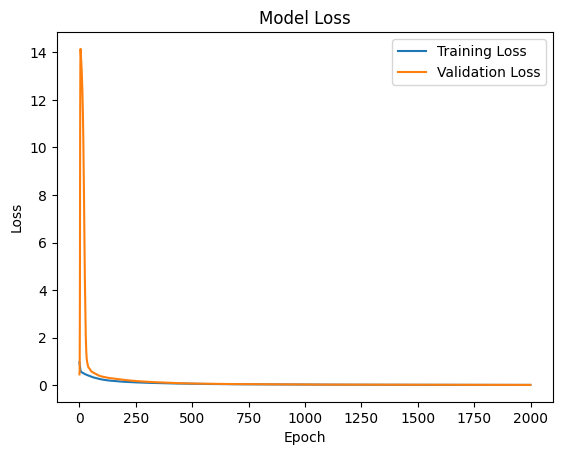

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 1s 1s/step


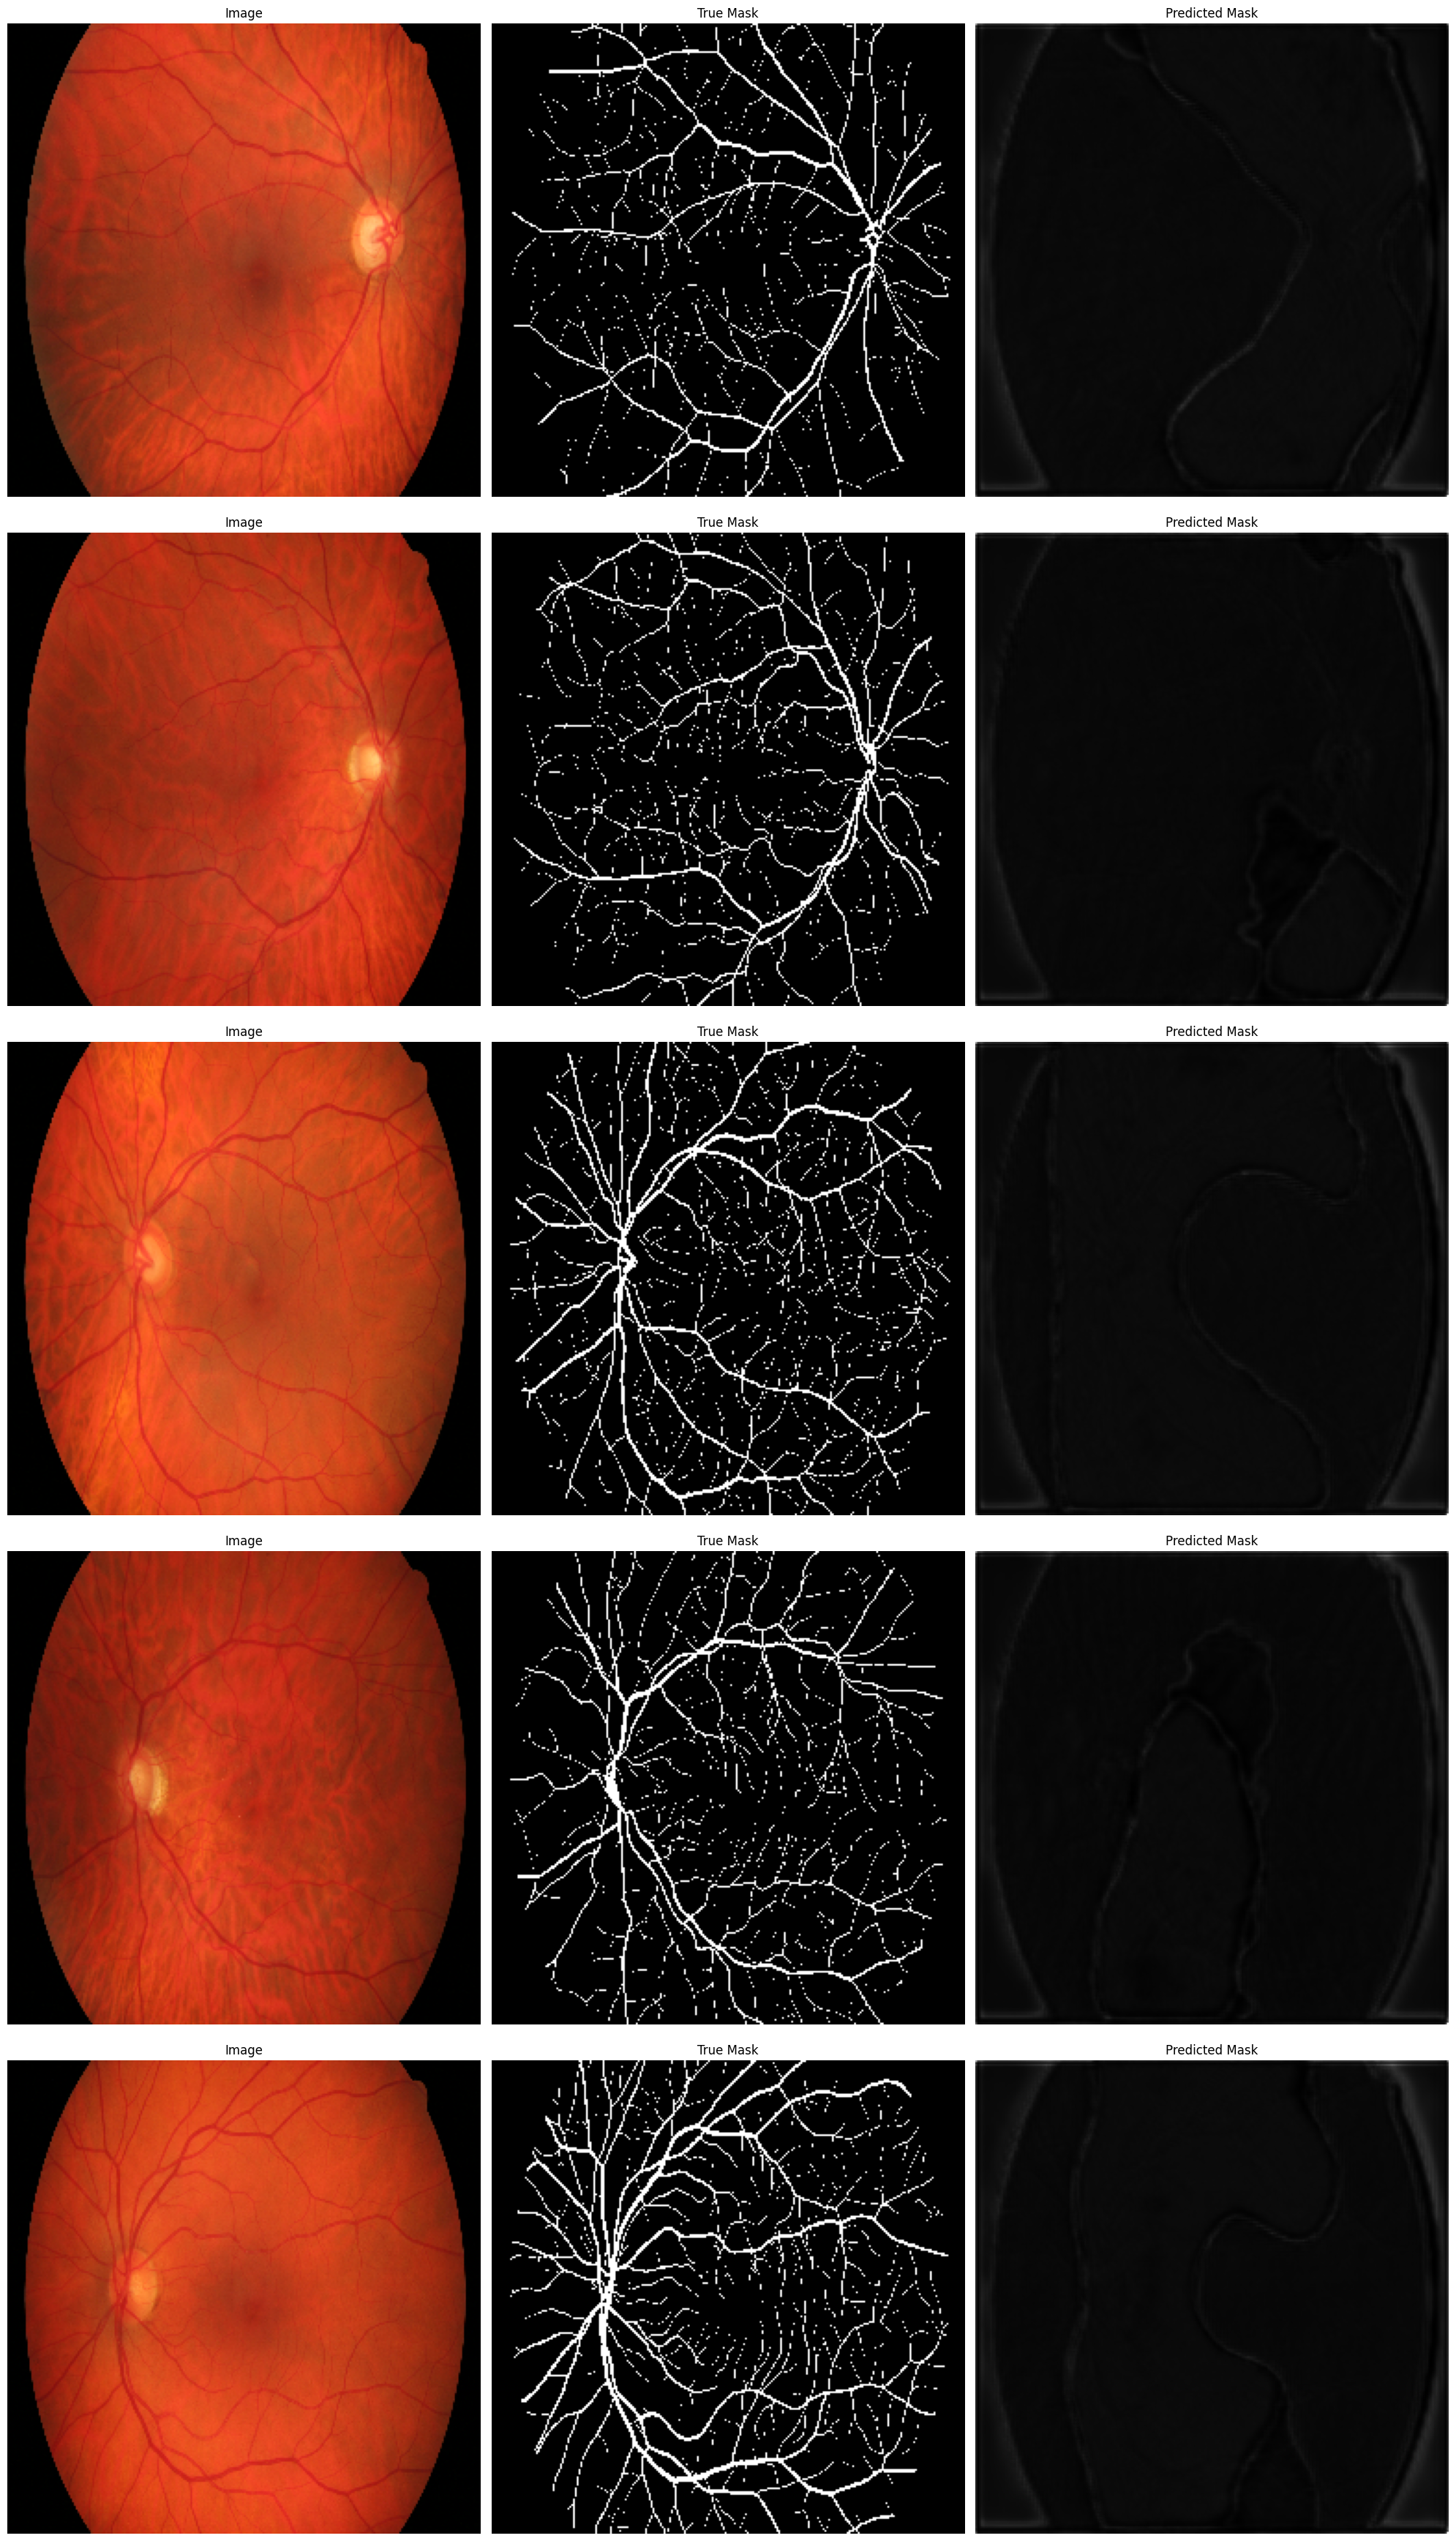

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import random

def adjust_brightness(image, factor=2.0):
    # Clip values to ensure they're within [0, 1] after scaling.
    return np.clip(image * factor, 0, 1)

def display_images_and_masks(images, true_masks, preds_masks, number_to_display=10):
    """
    Displays random images alongside their true masks and predicted masks with appropriate scaling.

    Args:
        images (numpy.ndarray): Array of images.
        true_masks (numpy.ndarray): Array of corresponding true masks.
        preds_masks (numpy.ndarray): Array of model predicted masks.
        number_to_display (int): Number of images to display.
    """
    plt.figure(figsize=(20, number_to_display * 7))

    for i in range(number_to_display):
        index = random.randint(0, len(images) - 1)
        image = images[index]
        true_mask = true_masks[index]
        predicted_mask = preds_masks[index]

        plt.subplot(number_to_display, 3, 3*i + 1)
        plt.imshow(image.squeeze())  # Original image colors
        plt.title('Image')
        plt.axis('off')

        plt.subplot(number_to_display, 3, 3*i + 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')  # Grayscale true masks
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(number_to_display, 3, 3*i + 3)
        plt.imshow(predicted_mask.squeeze(), cmap='gray')  # Adjusted contrast for predicted mask
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Suppose `model`, `X_train`, and `y_train` are already defined and the model is trained.
# Ensure `preds_masks` is a numpy array of predicted masks for `X_train` or a similar dataset
preds_masks = model.predict(X_train, verbose=1)

# Adjust the brightness for all predicted masks
adjusted_preds_masks = np.array([adjust_brightness(mask, factor=2.0) for mask in preds_masks])

# Now call your display function with the number of images set to 5
display_images_and_masks(X_train, y_train, adjusted_preds_masks, number_to_display=5)


<ipython-input-24-daccbf53f420>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(target_size, Image.ANTIALIAS)


1/1 [==============================] - 2s 2s/step


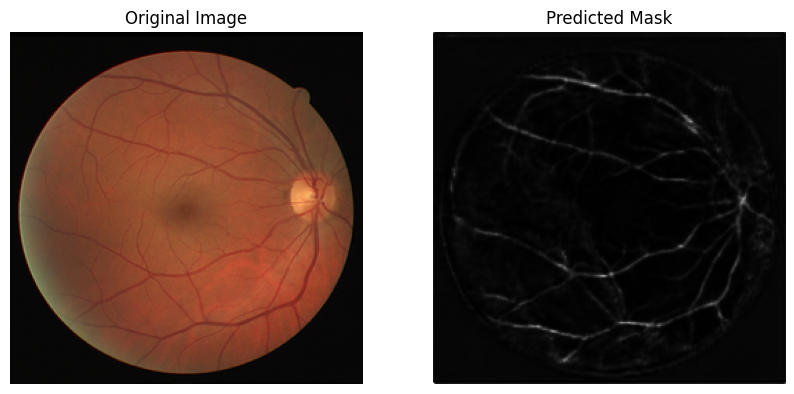

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

# Function to load and preprocess the new retinal image
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    # Load the image
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size, Image.ANTIALIAS)
    # Convert to numpy array and normalize
    img_array = img_to_array(img) / 255.0
    return img_array

# Load and preprocess the new retinal image
new_image_path = "/content/19_test.tif"  # Replace with the path to your new image
new_image = load_and_preprocess_image(new_image_path)

# Use the trained model to predict the mask for the new image
predicted_mask = model.predict(np.expand_dims(new_image, axis=0))[0]

# Adjust the brightness of the predicted mask
adjusted_predicted_mask = adjust_brightness(predicted_mask, factor=40.0)

# Visualize the original image and the predicted mask
plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(new_image)
plt.title("Original Image")
plt.axis("off")

# Display the predicted mask with adjusted brightness
plt.subplot(1, 2, 2)
plt.imshow(adjusted_predicted_mask.squeeze(), cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import glob
from tensorflow.keras.models import load_model
from PIL import Image

# Function to load an image
def load_image(filename, is_mask=False, target_size=(256, 256)):
    with Image.open(filename) as img:
        if is_mask:
            img = img.convert('L')  # Convert masks to grayscale
        else:
            img = img.convert('RGB')  # Ensure images are in RGB format
        img = img.resize(target_size, Image.Resampling.LANCZOS)  # Use LANCZOS for resizing
        pixels = np.array(img)
        if not is_mask:
            # Normalize the image data to [0, 1]
            pixels = pixels.astype('float32') / 255.0
        else:
            # Normalize mask data to [0, 1] if necessary
            pixels = (pixels > 127).astype('float32')  # Assuming the mask is a binary image
    return pixels

# Paths to the test images and masks
test_images_path = "/content/sample_data/DRIVE/test/images/"
test_masks_path = "/content/sample_data/DRIVE/test/mask/"

# Load test images and masks
X_test = np.array([load_image(image_file) for image_file in sorted(glob.glob(test_images_path + "*.tif"))])
y_test = np.array([load_image(mask_file, is_mask=True) for mask_file in sorted(glob.glob(test_masks_path + "*.gif"))])

# Check if data is loaded correctly
if len(X_test) == 0:
    raise ValueError("No test images found at the path: " + test_images_path)
if len(y_test) == 0:
    raise ValueError("No test masks found at the path: " + test_masks_path)

# Load your trained model, ensure you include the custom_objects if your model uses any
model = load_model('model_for_segmentation.h5', custom_objects={'dice_loss': dice_loss, 'dice_coefficient': dice_coefficient})

# Predict on the test set
preds_test = model.predict(X_test, verbose=1)

# Function to prepare images and masks for display
def prepare_for_display(image, mask=None, pred_mask=None):
    image_display = image
    mask_display = mask.squeeze() if mask is not None else None
    pred_mask_display = (pred_mask > 0.5).astype(np.float32).squeeze() if pred_mask is not None else None
    return image_display, mask_display, pred_mask_display

# Function to display the images and masks
def display_image_mask_pred(image, true_mask, predicted_mask):
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Test Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Mask')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()

# Choose a random test image
ix = random.randint(0, len(X_test) - 1)
image = X_test[ix]
true_mask = y_test[ix]
pred_mask = preds_test[ix]

# Prepare the selected image and masks for display
image_display, mask_display, pred_mask_display = prepare_for_display(image, true_mask, pred_mask)

# Display the image, the true mask, and the binary predicted mask
display_image_mask_pred(image_display, mask_display, pred_mask_display)


NameError: name 'dice_loss' is not defined

In [ ]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.5
!pip install -q keras==2.15.0
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import tensorflow as tf
import segmentation_models as sm
import numpy as np
import matplotlib.pyplot as plt

# Ensure compatibility with different versions of segmentation models and backends
sm.set_framework('tf.keras')
sm.framework()

# Clear previous TensorFlow session to free up RAM
#tf.keras.backend.clear_session()



ERROR: Could not find a version that satisfies the requirement tensorflow==2.5 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.5


'tf.keras'

In [ ]:
# Define the backbone
BACKBONE = 'efficientnetb0'
n_classes = 1
activation = 'sigmoid'

# Create the model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet')

# Compile the model
model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'binary_crossentropy'])

# Fit the model on the training data without EarlyStopping callback
history = model.fit(
    x=X_train,
    y=y_train_normalized,  # Ensure you're using normalized masks here as your target
    batch_size=5,
    epochs=400,
    validation_split=0.25,
    verbose=2
)


NameError: name 'X_train' is not defined

In [ ]:
def display_result(display_list):
    """
    Function to display the image, its mask, and the prediction.
    """
    plt.figure(figsize=(18, 6))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        if i == 2:  # For the Predicted Mask
            plt.imshow(display_list[i].squeeze(), cmap='gray')
        else:
            plt.imshow(display_list[i].squeeze())
        plt.axis('off')
    plt.show()

# Determine the number of images to display
num_images_to_display = min(len(X_val), len(y_val), 5)

# Display results for a few validation images
for i in range(num_images_to_display):
    test_image = X_val[i]
    true_mask = y_val[i]
    pred_mask = model.predict(np.expand_dims(test_image, axis=0))[0]  # Model prediction

    # Prepare the display list with the test image, true mask, and predicted mask
    display_list = [test_image, true_mask, pred_mask]

    # Display the results
    display_result(display_list)
